# Регуляризация

Модели глубокого обучения обладают большой гибкостью и набором параметров, поэтому **переобучение является серьёзной проблемой**, если обучающий набор данных недостаточно велик. Конечно, сеть хорошо работает на обучающем наборе, но **обладает плохой способностью к обобщению на новых примерах**.

**В рамках данной лабораторной работы будут приобретены  следующие навыки:** Использовать регуляризацию в  моделях глубокого обучения.

`Данный материал опирается и использует материалы курса Deep Learning от организации deeplearning.ai`
 
 Ссылка на осной курс (для желающих получить сертификаты): https://www.coursera.org/specializations/deep-learning

## 1 - Пакеты/Библиотеки ##

Первоначально необходимо запустить ячейку ниже, чтобы импортировать все пакеты, которые вам понадобятся во время лабораторной работы.
- [numpy](www.numpy.org) является основным пакетом для научных вычислений в Python.
- [matplotlib](http://matplotlib.org) это пакет для отрисовки графиков в Python.
- [sklearn](http://scikit-learn.org/stable/) предоставляет простые и эффективные инструменты для построения моделей и анализа данных.
- [scipy](https://www.scipy.org/) библиотека для работы со статистикой.
- reg_utils предоставляет различные полезные функции, используемые в данной лабораторной работе.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from reg_utils import sigmoid, relu, plot_decision_boundary, initialize_parameters, load_2D_dataset, predict_dec
from reg_utils import compute_cost, predict, forward_propagation, backward_propagation, update_parameters
import sklearn
import sklearn.datasets
import scipy.io
from testCases import *

%matplotlib inline
plt.rcParams['figure.figsize'] = (7.0, 4.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

/Users/maxkulagin/Desktop/google_cloud_jh/labsAI-rut/labs2/reg_utils.py:85: SyntaxWarning: assertion is always true, perhaps remove parentheses?
  assert(parameters['W' + str(l)].shape == layer_dims[l], layer_dims[l-1])
/Users/maxkulagin/Desktop/google_cloud_jh/labsAI-rut/labs2/reg_utils.py:86: SyntaxWarning: assertion is always true, perhaps remove parentheses?
  assert(parameters['W' + str(l)].shape == layer_dims[l], 1)


**Постановка задачи**: 
Представьте, что вы только что были наняты в качестве эксперта по искусственному интеллекту французской футбольной корпорацией. Они хотят, чтобы вы порекомендовали позиции, где вратарь сборной Франции должен бить по мячу, чтобы игроки французской команды могли затем ударить его головой. 

<img src="images/field_kiank.png" style="width:600px;height:350px;">
<caption><center> <u> **Рисунок 1** </u>: **Футбольное поле**<br> Вратарь бьет по мячу в воздух, игроки каждой команды борются, чтобы ударить по мячу головой </center></caption>

Далее представлен следующий 2-хмерный набор данных с последних 10 игр Франции.

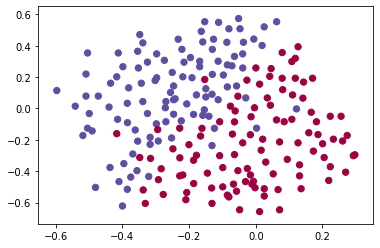

In [2]:
train_X, train_Y, test_X, test_Y = load_2D_dataset()

Каждая точка соответствует положению на футбольном поле, в котором футболист ударил головой по мячу после того, как французский голкипер выбел мяч с левой стороны футбольного поля.
- Если точка синяя, то это означает, что французский игрок успел ударить по мячу головой
- Если точка красная, это означает, что игрок другой команды ударил мяч головой

**Цель**: Используйте модель глубокого обучения, чтобы найти позиции на поле, где вратарь должен бить по мячу.

**Анализ набора данных**: этот набор данных немного зашумлен, но похоже, что диагональная линия, отделяющая верхнюю левую половину (синюю) от нижней правой половины (красная), будет работать хорошо. 

## 1 - Модель без регуляризации

Вы будете использовать следующую нейронную сеть (уже реализованную для вас ниже). Эту модель можно использовать:
- в параметре *regularization mode* -- установить `lambd` в не нулевое значение. 
- в параметре *dropout mode* -- установить `keep_prob`. Величина меньше 1.

Сначала необходимо попробовать модель без какой-либо регуляризации. Затем осуществить:
- *L2 regularization* -- "`compute_cost_with_regularization()`" и "`backward_propagation_with_regularization()`"
- *Dropout* -- "`forward_propagation_with_dropout()`" и "`backward_propagation_with_dropout()`"

In [3]:
def model(X, Y, learning_rate = 0.3, num_iterations = 30000, print_cost = True, lambd = 0, keep_prob = 1):
    """
    3-х слойнная нейронная сеть с архитектурой: LINEAR->RELU->LINEAR->RELU->LINEAR->SIGMOID.
    
    Arguments:
    X -- матрица признаков (input size, number of examples)
    Y -- вектор меток (0 - красная точка; 1 - голубая точка), с размером (output size, number of examples)
    learning_rate -- скорость градиентного спуска 
    num_iterations -- количество итераций при обучении
    print_cost -- True печать каждые 100 шагов
    lambd --гиперпараметр регуляризации
    keep_prob - вероятность сохранения нейрона активным во время drop-out
    
    Returns:
    parameters -- обученные параметры модели
    """
        
    grads = {}
    costs = []
    m = X.shape[1]
    layers_dims = [X.shape[0], 20, 3, 1]
    
    # Инициализация параметров
    parameters = initialize_parameters(layers_dims)
    for i in range(0, num_iterations):

        # Прямое распространение: LINEAR -> RELU -> LINEAR -> RELU -> LINEAR -> SIGMOID.
        if keep_prob == 1:
            a3, cache = forward_propagation(X, parameters)
        elif keep_prob < 1:
            a3, cache = forward_propagation_with_dropout(X, parameters, keep_prob)
        
        # Функция потерь
        if lambd == 0:
            cost = compute_cost(a3, Y)
        else:
            cost = compute_cost_with_regularization(a3, Y, parameters, lambd)
            
        # Обратное распротранение
        assert(lambd==0 or keep_prob==1)
        if lambd == 0 and keep_prob == 1:
            grads = backward_propagation(X, Y, cache)
        elif lambd != 0:
            grads = backward_propagation_with_regularization(X, Y, cache, lambd)
        elif keep_prob < 1:
            grads = backward_propagation_with_dropout(X, Y, cache, keep_prob)
        
        # Обновление параметров
        parameters = update_parameters(parameters, grads, learning_rate)
        
        if print_cost and i % 10000 == 0:
            print("Потери после итерации {}: {}".format(i, cost))
        if print_cost and i % 1000 == 0:
            costs.append(cost)
    
    # plot the cost
    plt.plot(costs)
    plt.ylabel('потери')
    plt.xlabel('итерации')
    plt.title("Размер градиентного шага =" + str(learning_rate))
    plt.show()
    
    return parameters

Потери после итерации 0: 0.6557412523481002
Потери после итерации 10000: 0.16329987525724213
Потери после итерации 20000: 0.1385164242326018


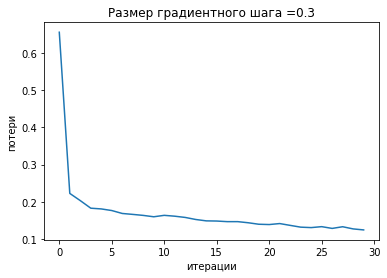

Обучающий датасет:
Accuracy: 0.9478672985781991
Тестовый датасет:
Accuracy: 0.915


In [4]:
parameters = model(train_X, train_Y)
print ("Обучающий датасет:")
predictions_train = predict(train_X, train_Y, parameters)
print ("Тестовый датасет:")
predictions_test = predict(test_X, test_Y, parameters)

Точность на train составляет 94,8% , а точность на тесте-91,5%. Это **baseline model**.

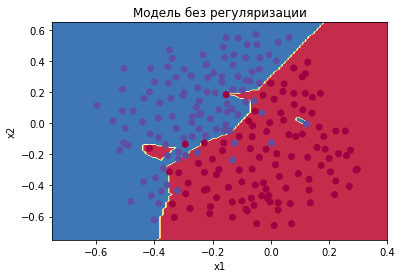

In [7]:
plt.title("Модель без регуляризации")
axes = plt.gca()
axes.set_xlim([-0.75,0.40])
axes.set_ylim([-0.75,0.65])
plot_decision_boundary(lambda x: predict_dec(parameters, x.T), train_X, train_Y[0])

Модель без регурялизации, очевидно, переобучена на обучающем наборе. Это соответствует шумным точкам!

## 2 - L2 регуляризация

Стандартный способ борьбы с переобучением называется **L2 регуляризация**. Он состоит из соответствующего изменения функции затрат с:
$$J = -\frac{1}{m} \sum\limits_{i = 1}^{m} \large{(}\small  y^{(i)}\log\left(a^{[L](i)}\right) + (1-y^{(i)})\log\left(1- a^{[L](i)}\right) \large{)} \tag{1}$$
на:
$$J_{regularized} = \small \underbrace{-\frac{1}{m} \sum\limits_{i = 1}^{m} \large{(}\small y^{(i)}\log\left(a^{[L](i)}\right) + (1-y^{(i)})\log\left(1- a^{[L](i)}\right) \large{)} }_\text{cross-entropy cost} + \underbrace{\frac{1}{m} \frac{\lambda}{2} \sum\limits_l\sum\limits_k\sum\limits_j W_{k,j}^{[l]2} }_\text{L2 regularization cost} \tag{2}$$

**Упражнение**: Реализуйте `compute_cost_with_regularization()` которая вычисляет значение функции потерь по формуле (2). Вычислите $\sum\limits_k\sum\limits_j W_{k,j}^{[l]2}$  , используя:
```python
np.sum(np.square(Wl))
```
Обратите внимание, что необходимо сделать это для $W^{[1]}$, $W^{[2]}$ и $W^{[3]}$, затем сложите все три члена и умножьте на $ \frac{1}{m} \frac{\lambda}{2} $.

In [8]:
# ОЦЕНИВАЕМОЕ: compute_cost_with_regularization

def compute_cost_with_regularization(A3, Y, parameters, lambd):
    """
    Функция потерь с L2 регуляризацией
    
    Arguments:
    A3 -- выход прямого распространения, размер (output size, number of examples)
    Y -- вектор меток (output size, number of examples)
    parameters -- словарь python, содержащий параметры модели
    
    Returns:
    cost - значение регуляризованной функции потерь
    """
    m = Y.shape[1]
    W1 = parameters["W1"]
    W2 = parameters["W2"]
    W3 = parameters["W3"]
    
    cross_entropy_cost = compute_cost(A3, Y)
    
    ### НАЧАЛО ВАШЕГО КОД ЗДЕСЬ ### (примерно 1 срока кода)
    L2_regularization_cost = (1/m)*(lambd/2)*np.sum(np.sum(np.square(W1)) + np.sum(np.square(W2)) + np.sum(np.square(W3)))
    ### ОКОНЧАНИЕ ВАШЕГО КОД ЗДЕСЬ ###
    
    cost = cross_entropy_cost + L2_regularization_cost
    
    return cost

In [10]:
A3, Y_assess, parameters = compute_cost_with_regularization_test_case()

print("cost = " + str(compute_cost_with_regularization(A3, Y_assess, parameters, lambd = 0.1)))

cost = 1.7864859451590758


**Ожидаемый результат**: 

<table> 
    <tr>
    <td>
    **cost**
    </td>
        <td>
    1.78648594516
    </td>
    </tr>
</table> 

Конечно, поскольку была изменена функция потерь, должно быть изменено обратное распространение! Все градиенты должны быть рассчитаны с учетом этой новой функцией потерь.

**Упражнение**: Реализуйте изменения, необходимые в обратном распространении, чтобы учесть регуляризацию. Изменения касаются только dW1, dW2 и dW3. Для каждого из них необходимо добавить градиент регуляризационного члена ($\frac{d}{dW} ( \frac{1}{2}\frac{\lambda}{m}  W^2) = \frac{\lambda}{m} W$).

In [11]:
# ОЦЕНИВАЕМОЕ: backward_propagation_with_regularization

def backward_propagation_with_regularization(X, Y, cache, lambd):
    """
    Функция обратного распространения базовой модели, к которой добавлена регуляризация L2.
    
    Arguments:
    X -- матрица признаков(input size, number of examples)
    Y -- вектор меток (output size, number of examples)
    cache -- кэш из функции forward_propagation()
    lambd -- параметр регуляризации
    
    Returns:
    gradients -- словарь с градиентами относительно каждого параметра, переменных активации
    """
    
    m = X.shape[1]
    (Z1, A1, W1, b1, Z2, A2, W2, b2, Z3, A3, W3, b3) = cache
    
    dZ3 = A3 - Y
    
    ### НАЧАЛО ВАШЕГО КОД ЗДЕСЬ ### (примерно 1 срока кода)
    dW3 = 1./m * np.dot(dZ3, A2.T) + (lambd/m)*W3
    ### ОКОНЧАНИЕ ВАШЕГО КОД ЗДЕСЬ ###
    db3 = 1./m * np.sum(dZ3, axis=1, keepdims = True)
    
    dA2 = np.dot(W3.T, dZ3)
    dZ2 = np.multiply(dA2, np.int64(A2 > 0))
    ### НАЧАЛО ВАШЕГО КОД ЗДЕСЬ ### (примерно 1 срока кода)
    dW2 = 1./m * np.dot(dZ2, A1.T) + (lambd/m)*W2
    ### ОКОНЧАНИЕ ВАШЕГО КОД ЗДЕСЬ ###
    db2 = 1./m * np.sum(dZ2, axis=1, keepdims = True)
    
    dA1 = np.dot(W2.T, dZ2)
    dZ1 = np.multiply(dA1, np.int64(A1 > 0))
    ### НАЧАЛО ВАШЕГО КОД ЗДЕСЬ ### (примерно 1 срока кода)
    dW1 = 1./m * np.dot(dZ1, X.T) + (lambd/m)*W1
    ### ОКОНЧАНИЕ ВАШЕГО КОД ЗДЕСЬ ###
    db1 = 1./m * np.sum(dZ1, axis=1, keepdims = True)
    
    gradients = {"dZ3": dZ3, "dW3": dW3, "db3": db3,"dA2": dA2,
                 "dZ2": dZ2, "dW2": dW2, "db2": db2, "dA1": dA1, 
                 "dZ1": dZ1, "dW1": dW1, "db1": db1}
    
    return gradients

In [12]:
X_assess, Y_assess, cache = backward_propagation_with_regularization_test_case()

grads = backward_propagation_with_regularization(X_assess, Y_assess, cache, lambd = 0.7)
print ("dW1 = "+ str(grads["dW1"]))
print ("dW2 = "+ str(grads["dW2"]))
print ("dW3 = "+ str(grads["dW3"]))

dW1 = [[-0.25604646  0.12298827 -0.28297129]
 [-0.17706303  0.34536094 -0.4410571 ]]
dW2 = [[ 0.79276486  0.85133918]
 [-0.0957219  -0.01720463]
 [-0.13100772 -0.03750433]]
dW3 = [[-1.77691347 -0.11832879 -0.09397446]]


**Ожидаемый результат**:

<table> 
    <tr>
    <td>
    **dW1**
    </td>
        <td>
    [[-0.25604646  0.12298827 -0.28297129]
 [-0.17706303  0.34536094 -0.4410571 ]]
    </td>
    </tr>
    <tr>
    <td>
    **dW2**
    </td>
        <td>
    [[ 0.79276486  0.85133918]
 [-0.0957219  -0.01720463]
 [-0.13100772 -0.03750433]]
    </td>
    </tr>
    <tr>
    <td>
    **dW3**
    </td>
        <td>
    [[-1.77691347 -0.11832879 -0.09397446]]
    </td>
    </tr>
</table> 

Запустите модель с L2 регуляризацией $(\lambda = 0.7)$ `model()`: 
- `compute_cost_with_regularization` вместо `compute_cost`
- `backward_propagation_with_regularization` вместо `backward_propagation`

Потери после итерации 0: 0.6974484493131264
Потери после итерации 10000: 0.2684918873282238
Потери после итерации 20000: 0.26809163371273004


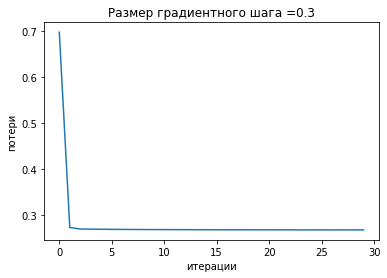

Обучающий датасет:
Accuracy: 0.9383886255924171
Тестовый датасет:
Accuracy: 0.93


In [13]:
parameters = model(train_X, train_Y, lambd = 0.7)
print ("Обучающий датасет:")
predictions_train = predict(train_X, train_Y, parameters)
print ("Тестовый датасет:")
predictions_test = predict(test_X, test_Y, parameters)

Точность на тестовой выборке увеличилась до 93%.

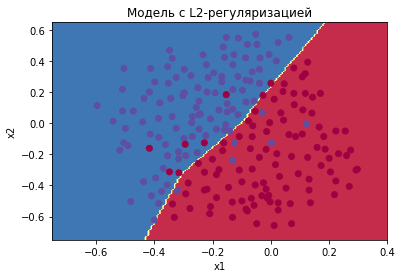

In [15]:
plt.title("Модель с L2-регуляризацией")
axes = plt.gca()
axes.set_xlim([-0.75,0.40])
axes.set_ylim([-0.75,0.65])
plot_decision_boundary(lambda x: predict_dec(parameters, x.T), train_X, train_Y[0])

**Наблюдения**:
-  $\lambda$ это гиперпараметр, который необходимо подбирать.
- L2 регуляризация делает границы решения более гладкими. Если $\lambda$ имеет сильно большое значение, в результате чего получается модель с большим смещнением.

**Что на самом деле делает L2-регуляризация?**:

L2-регуляризация основана на предположении, что модель с небольшими весами проще, чем с большими. Таким образом, штрафуя квадраты значений весов в функции потерь, все веса приводятся к меньшим значениям. Это становится затратно для функции стоимости иметь слишком большие веса! Что приводит к более гладкой модели.

<font color='blue'>
    
**Что необходимо помнить:** -- влияние L2-регуляризации на:
- Вычисление функции потерь:
    - К стоимости добавляется член регуляризации
- Функцию обратного распространения:
    - Существуют дополнительные члены в градиентах относительно весовых матриц
- Веса в конечном итоге становятся меньше ("weight decay"): 
    - Значение весов уменьшается.

## 3 - Dropout

Наконец, **dropout** - это широко используемый метод регуляризации, специфичный для глубокого обучения. 
**Он случайным образом отключает некоторые нейроны на каждой итерации** Посмотрите эти два видео, чтобы понять, что это значит!

<!--
To understand drop-out, consider this conversation with a friend:
- Friend: "Why do you need all these neurons to train your network and classify images?". 
- You: "Because each neuron contains a weight and can learn specific features/details/shape of an image. The more neurons I have, the more featurse my model learns!"
- Friend: "I see, but are you sure that your neurons are learning different features and not all the same features?"
- You: "Good point... Neurons in the same layer actually don't talk to each other. It should be definitly possible that they learn the same image features/shapes/forms/details... which would be redundant. There should be a solution."
!--> 

<center>
<video width="620" height="440" src="images/dropout1_kiank.mp4" type="video/mp4" controls>
</video>
</center>
<br>
<caption><center> <u> Рисунок 2 </u>: Drop-out во втором скрытом слое. <br> 
    На каждой итерации вы закрываете (=устанавливаете на ноль) каждый нейрон слоя с вероятностью $1 - keep\_prob$ или держите его с вероятностью $keep\_prob$ (здесь $keep\_prob =$ 50%). Отброшенные нейроны не участвуют в обучении как в прямом, так и в обратном распространении.
 </center></caption>

<center>
<video width="620" height="440" src="images/dropout2_kiank.mp4" type="video/mp4" controls>
</video>
</center>

<caption><center> <u> Рисунок 3 </u>: Drop-out в первом и третьем скрытом слое. <br> $1^{ый}$ слой: Отключается в среднем 40% нейронов.  $3^{ий}$ слой: Отключается в среднем 20% нейронов.. </center></caption>

Когда вы отключаете некоторые нейроны, вы фактически изменяете свою модель. Идея drop-out заключается в том, что на каждой итерации вы тренируете другую модель, которая использует только подмножество нейронов. При drop-out нейроны, таким образом, становятся менее чувствительными к активации  других нейронов, потому что этот другой нейрон может быть выключен в любой момент.

### 3.1 - Прямое распространение с dropout

**Упражнение**: Реализовать прямое распространение с dropout. Добавить dropout к первому и второму скрытым слоям.

**Инструкции**:
Для поставленной задачи вам предстоит выполнить 4 шага
1. В лекции мы решили создать переменную $d^{[1]}$ с той же формой, что и $a^{[1]}$, используя `np.random.rand()` для случайного получения чисел от 0 до 1. Здесь вы будете использовать векторизованную реализацию, поэтому создайте случайную матрицу $D^{[1]} = [d^{[1](1)} d^{[1](2)} ... d^{[1](m)}] $ той же размерности, что и $A^{[1]}$.
2. Установите для каждой записи $D^{[1]}$ значение 0 с вероятностью (`1-keep_prob`) или 1 с вероятностью (`keep_prob`), задав пороговые значения в $D^{[1]}$ соответствующим образом. Подсказка: чтобы установить все записи матрицы X в 0 (если запись меньше 0,5) или 1 (Если запись больше 0,5), вы должны сделать: `X = (X < 0,5)`. Обратите внимание, что 0 и 1 соответственно эквивалентны False и True.
3. Установите $A^{[1]}$ в $A^{[1]} * D^{[1]}$. (Вы отключаете некоторые нейроны). Вы представить $D^{[1]}$ как маску, так что, когда она умножается на другую матрицу, она закрывает некоторые из значений.
4. Разделите $A^{[1]}$ на `keep_prob`. Делая это, вы гарантируете, что результат затрат по-прежнему будет иметь то же ожидаемое значение, что и без drop-out.

In [16]:
# ОЦЕНИВАЕМОЕ: forward_propagation_with_dropout

def forward_propagation_with_dropout(X, parameters, keep_prob = 0.5):
    """
    Реализация прямого распространения: LINEAR -> RELU + DROPOUT -> LINEAR -> RELU + DROPOUT -> LINEAR -> SIGMOID.
    
    Arguments:
    X -- матрица признаков (2, number of examples)
    parameters -- словарь python, содержащий параметры "W1", "b1", "W2", "b2", "W3", "b3":
                    W1 -- матрица весов в 1 слое (20, 2)
                    b1 -- вектор смещений в 1 слое (20, 1)
                    W2 -- матрица весов во 2 слое (3, 20)
                    b2 -- вектор смещений во 2 слое (3, 1)
                    W3 -- матрица весов в 3 слое (1, 3)
                    b3 -- вектор смещений в 3 слое (1, 1)
    keep_prob - вероятность сохранения активности нейрона drop-out
    
    Returns:
    A3 -- последнее значение активации, выход с прямого распространения (1,1)
    cache -- кортеж, информация, хранящаяся для вычисления обратного распространения
    """
    
    np.random.seed(1)
    
    W1 = parameters["W1"]
    b1 = parameters["b1"]
    W2 = parameters["W2"]
    b2 = parameters["b2"]
    W3 = parameters["W3"]
    b3 = parameters["b3"]
    
    # LINEAR -> RELU -> LINEAR -> RELU -> LINEAR -> SIGMOID
    Z1 = np.dot(W1, X) + b1
    A1 = relu(Z1)
    ### НАЧАЛО ВАШЕГО КОД ЗДЕСЬ ### (примерно 4 строки кода) # Шаги 1-4 соответствует шагам 1-4 описанным выше. 
    D1 = np.random.rand(A1.shape[0], A1.shape[1]) # Шаг 1: Инициализация матрицы D1 = np.random.rand(..., ...)
    D1 = (D1 < keep_prob)           # Шаг 2: конвертация D1 к 0 или 1 (используя keep_prob как порог)
    A1 = A1*D1                      # Шаг 3: отключить несколько нейронов
    A1 = A1/keep_prob               # Шаг 4: масштабируйте значение нейронов, которые еще не были отключены
    ### ОКОНЧАНИЕ ВАШЕГО КОД ЗДЕСЬ ###
    Z2 = np.dot(W2, A1) + b2
    A2 = relu(Z2)
    ### НАЧАЛО ВАШЕГО КОД ЗДЕСЬ ### (примерно 4 строки кода)
    D2 = np.random.rand(A2.shape[0], A2.shape[1]) # Шаг 1: Инициализация матрицы D2 = np.random.rand(..., ...)
    D2 = (D2 < keep_prob)   # Шаг 2: конвертация D2 к 0 или 1 (используя keep_prob как порог)
    A2 = A2*D2              # Шаг 3: отключить несколько нейронов для A2
    A2 = A2/keep_prob       # Шаг 4: масштабируйте значение нейронов, которые еще не были отключены
    ### ОКОНЧАНИЕ ВАШЕГО КОД ЗДЕСЬ ###
    Z3 = np.dot(W3, A2) + b3
    A3 = sigmoid(Z3)
    
    cache = (Z1, D1, A1, W1, b1, Z2, D2, A2, W2, b2, Z3, A3, W3, b3)
    
    return A3, cache

In [17]:
X_assess, parameters = forward_propagation_with_dropout_test_case()

A3, cache = forward_propagation_with_dropout(X_assess, parameters, keep_prob = 0.7)
print ("A3 = " + str(A3))

A3 = [[0.36974721 0.00305176 0.04565099 0.49683389 0.36974721]]


**Ожидаемый результат**: 

<table> 
    <tr>
    <td>
    **A3**
    </td>
        <td>
    [[ 0.36974721  0.00305176  0.04565099  0.49683389  0.36974721]]
    </td>
    </tr>
</table> 

### 3.2 - Обратное распространение с dropout

**Упражнение**: Реализуйте обратное распространение с dropout. Добавьте dropout к первому и второму скрытым слоям, используя маски $D^{[1]}$ и $D^{[2]}$, хранящиеся в cache.

**Инструкция**:
Обратное распространение с dropout делается в 2 шага:
1. Ранее отключили некоторые нейроны во время прямого распространения, применив маску $D^{[1]}$ к `A1`. При обратном распространении придется отключить те же самые нейроны, повторно применив ту же самую маску $D^{[1]}$ к `dA1`. 
2. Во время прямого распространения  `A1` разделили на `keep_prob`. В методе обратного распространения ошибки необходимо делить `dA1` на `keep_prob` снова (смысл заключается в том, что если $A^{[1]}$ масштабируется на `keep_prob`, то ее производная $dA^{[1]}$ тоже масштабируется от одного и того же `keep_prob`).

In [18]:
# ОЦЕНИВАЕМОЕ: backward_propagation_with_dropout

def backward_propagation_with_dropout(X, Y, cache, keep_prob):
    """
    Реализация обратного распространени для baseline model в которой добавлен dropout.
    
    Arguments:
    X -- матрица признаков (2, number of examples)
    Y -- вектор меток (output size, number of examples)
    cache -- cache выход из forward_propagation_with_dropout()
    keep_prob - вероятность сохранения активности нейрона drop-out
    
    Returns:
    gradients -- словарь с градиентами относительно каждого параметра и функции активации
    """
    
    m = X.shape[1]
    (Z1, D1, A1, W1, b1, Z2, D2, A2, W2, b2, Z3, A3, W3, b3) = cache
    
    dZ3 = A3 - Y
    dW3 = 1./m * np.dot(dZ3, A2.T)
    db3 = 1./m * np.sum(dZ3, axis=1, keepdims = True)
    dA2 = np.dot(W3.T, dZ3)
    ### НАЧАЛО ВАШЕГО КОД ЗДЕСЬ ### (≈ 2 строки кода)
    dA2 = dA2*D2             # Шаг 1: Применить маску D2 чтобы отключить те же нейроны, что и при прямом распространении
    dA2 = dA2/keep_prob      # Шаг 2: масштабируйте значение нейронов, которые еще не были отключены
    ### ОКОНЧАНИЕ ВАШЕГО КОД ЗДЕСЬ ###
    dZ2 = np.multiply(dA2, np.int64(A2 > 0))
    dW2 = 1./m * np.dot(dZ2, A1.T)
    db2 = 1./m * np.sum(dZ2, axis=1, keepdims = True)
    
    dA1 = np.dot(W2.T, dZ2)
    ### НАЧАЛО ВАШЕГО КОД ЗДЕСЬ ### (≈ 2 строки кода)
    dA1 = dA1*D1              # Шаг 1: Применить маску D1 чтобы отключить те же нейроны, что и при прямом распространении
    dA1 = dA1/keep_prob       # Шаг 2: масштабируйте значение нейронов, которые еще не были отключены
    ### ОКОНЧАНИЕ ВАШЕГО КОД ЗДЕСЬ ###
    dZ1 = np.multiply(dA1, np.int64(A1 > 0))
    dW1 = 1./m * np.dot(dZ1, X.T)
    db1 = 1./m * np.sum(dZ1, axis=1, keepdims = True)
    
    gradients = {"dZ3": dZ3, "dW3": dW3, "db3": db3,"dA2": dA2,
                 "dZ2": dZ2, "dW2": dW2, "db2": db2, "dA1": dA1, 
                 "dZ1": dZ1, "dW1": dW1, "db1": db1}
    
    return gradients

In [19]:
X_assess, Y_assess, cache = backward_propagation_with_dropout_test_case()

gradients = backward_propagation_with_dropout(X_assess, Y_assess, cache, keep_prob = 0.8)

print ("dA1 = " + str(gradients["dA1"]))
print ("dA2 = " + str(gradients["dA2"]))

dA1 = [[ 0.36544439  0.         -0.00188233  0.         -0.17408748]
 [ 0.65515713  0.         -0.00337459  0.         -0.        ]]
dA2 = [[ 0.58180856  0.         -0.00299679  0.         -0.27715731]
 [ 0.          0.53159854 -0.          0.53159854 -0.34089673]
 [ 0.          0.         -0.00292733  0.         -0.        ]]


**Ожидаемый результат**: 

<table> 
    <tr>
    <td>
    **dA1**
    </td>
        <td>
    [[ 0.36544439  0.         -0.00188233  0.         -0.17408748]
 [ 0.65515713  0.         -0.00337459  0.         -0.        ]]
    </td>
    </tr>
    <tr>
    <td>
    **dA2**
    </td>
        <td>
    [[ 0.58180856  0.         -0.00299679  0.         -0.27715731]
 [ 0.          0.53159854 -0.          0.53159854 -0.34089673]
 [ 0.          0.         -0.00292733  0.         -0.        ]]
    </td>
    </tr>
</table> 

Запустим модель с dropout (`keep_prob = 0.86`). Это означает, что на каждой итерации отключается каждый нейрон слоя 1 и 2 с вероятностью 24%. `model()` использует:
- `forward_propagation_with_dropout` вместо `forward_propagation`.
- `backward_propagation_with_dropout` вместо `backward_propagation`.

Потери после итерации 0: 0.6543912405149825


/Users/maxkulagin/Desktop/google_cloud_jh/labsAI-rut/labs2/reg_utils.py:236: RuntimeWarning: divide by zero encountered in log
  logprobs = np.multiply(-np.log(a3),Y) + np.multiply(-np.log(1 - a3), 1 - Y)
/Users/maxkulagin/Desktop/google_cloud_jh/labsAI-rut/labs2/reg_utils.py:236: RuntimeWarning: invalid value encountered in multiply
  logprobs = np.multiply(-np.log(a3),Y) + np.multiply(-np.log(1 - a3), 1 - Y)


Потери после итерации 10000: 0.061016986574905605
Потери после итерации 20000: 0.060582435798513114


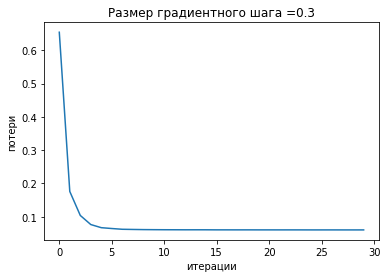

Обучающий датасет:
Accuracy: 0.9289099526066351
Тестовый датасет:
Accuracy: 0.95


In [20]:
parameters = model(train_X, train_Y, keep_prob = 0.86, learning_rate = 0.3)
print ("Обучающий датасет:")
predictions_train = predict(train_X, train_Y, parameters)
print ("Тестовый датасет:")
predictions_test = predict(test_X, test_Y, parameters)

Точность на тестовой выборке увеличилась до 95%. Модель не слишком подходит для обучающего набора и отлично справляется с тестовым набором. 

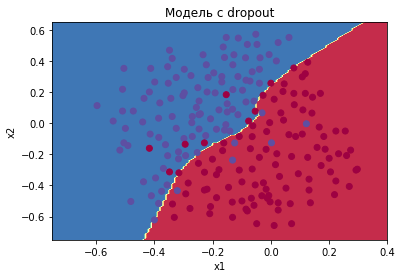

In [21]:
plt.title("Модель с dropout")
axes = plt.gca()
axes.set_xlim([-0.75,0.40])
axes.set_ylim([-0.75,0.65])
plot_decision_boundary(lambda x: predict_dec(parameters, x.T), train_X, train_Y[0])

**Заметки**:
- **Распространенная ошибка** при использовании dropout заключается в использовании его как для обучающей, так и для тестовой выборки. Необходимо использовать dropout (случайное исключение узлов) только для обучающей выборки.
- Фреймворки глубокого обучения: [tensorflow](https://www.tensorflow.org/api_docs/python/tf/nn/dropout), [PaddlePaddle](http://doc.paddlepaddle.org/release_doc/0.9.0/doc/ui/api/trainer_config_helpers/attrs.html), [keras](https://keras.io/layers/core/#dropout) или [caffe](http://caffe.berkeleyvision.org/tutorial/layers/dropout.html) использует готовую реализацию для dropout слоев.

<font color='blue'>
    
**Что необходимо помнить о dropout:**
- Dropout техника регуляризации.
- Использовать данную технику только для обучения. Не использовать dropout для тестовой выборки
- Применение dropout для прямого и обратного распространения
- Во время обучения разделите каждый слой dropout на keep_prob, чтобы сохранить одно и то же ожидаемое значение для активаций. Например, если keep_prob равен 0.5, то мы в среднем отключим половину узлов, поэтому выход будет масштабирован на 0.5, поскольку только оставшаяся половина вносит свой вклад в решение. Деление на 0.5 эквивалентно умножению на 2. Следовательно, выход теперь имеет то же самое ожидаемое значение.

## 4 - Выводы

**Результаты 3-х моделей**: 

<table> 
    <tr>
        <td>
        **model**
        </td>
        <td>
        **Точность на обучении**
        </td>
        <td>
        **Точность на тесте**
        </td>
    </tr>
        <td>
        3-слойнная NN без регуляризации
        </td>
        <td>
        95%
        </td>
        <td>
        91.5%
        </td>
    <tr>
        <td>
        3-слойнная NN с L2-регуляризации
        </td>
        <td>
        94%
        </td>
        <td>
        93%
        </td>
    </tr>
    <tr>
        <td>
        3-слойнная NN с dropout
        </td>
        <td>
        93%
        </td>
        <td>
        95%
        </td>
    </tr>
</table> 

Обратите внимание, что регуляризация вредит качеству на обучающем наборе! Это связано с тем, что есть ограничение способность сети перестраиваться на обучающий набор. Но поскольку это в конечном счете дает лучшую точность на тесте, это помогает системе.

<font color='blue'>
    
**Что необходимо помнить**:
- Регуляризация помогает уменьшить эффект переобучения.
- Регуляризация приводит веса к более низким значениям.
- L2 регуляризация и dropout есть два очень эффективных метода регуляризации.